In [927]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

In [928]:
def generate_data(n_samples, noise, t1=6, t2=8, t3=9, low=0, high=10):
    n_samples = 1000

    X1 = np.random.uniform(low, high, size=(n_samples,1))
    X2 = np.random.choice([0, 1], size=(n_samples,1))
    X = np.concatenate((X1, X2), axis=1)

    # labels generated according to thresholds
    y = np.zeros(n_samples)
    y[np.where((X[:,0] > t1) & (X[:,0] < t2))] = 1
    y[np.where(X[:, 0] > t3)] = 1

    # Groups
    g1_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t1) & (X[:,1] == 0.))
    g1g2 = np.where((X[:,0] > t2) & (X[:,0] < t3))
    g2_disjoint = np.where((X[:,0] > 0) & (X[:,0] < t3) & (X[:,1] == 1.))

    g1 = np.union1d(g1_disjoint, g1g2)
    g2 = np.union1d(g2_disjoint, g1g2)
    g3 = np.where((X[:,0] > t2))
    g1g2g3 = np.intersect1d(g1g2, g3)

    # Disagreement region
    # Vary between random noise and completely deterministic
    y[g1g2g3] = np.random.choice([0, 1], size=len(g1g2g3), p=[1-noise, noise])
    return X, y, [g1,g2,g3,g1g2,g1g2g3]

## Sanity Checks

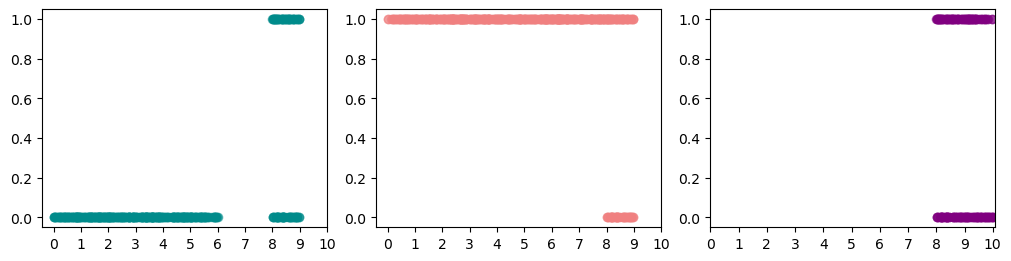

P(g1)=0.4
P(g2)=0.505
P(g3)=0.17
P(g1g2)=0.09
P(g1g2g3)=0.09


In [929]:
# Construct counterexample distribution
# thresholds for changes in P(Y = 1 | X1)
n_samples = 1000
noise = 0.4
X, y, [g1,g2,g3,g1g2,g1g2g3] = generate_data(n_samples=n_samples, noise=noise)
X1 = X[:,0]
X2 = X[:,1]

# Check groups are okay
fig, axs = plt.subplots(1, 3, figsize=(10, 2.5), layout='constrained')
xticks = range(11)
axs[0].scatter(X1[g1], X2[g1], alpha=0.5, color="darkcyan")
axs[0].set_xticks(xticks)
axs[1].scatter(X1[g2], X2[g2], alpha=0.5, color="lightcoral")
axs[1].set_xticks(xticks)
axs[2].scatter(X1[g3], X2[g3], alpha=0.5, color="purple" )
axs[2].set_xticks(xticks)
plt.show()

# Mass of each group and intersection
print("P(g1)={}".format(len(X[g1])/n_samples))
print("P(g2)={}".format(len(X[g2])/n_samples))
print("P(g3)={}".format(len(X[g3])/n_samples))
print("P(g1g2)={}".format(len(X[g1g2])/n_samples))
print("P(g1g2g3)={}".format(len(X[g1g2g3])/n_samples))

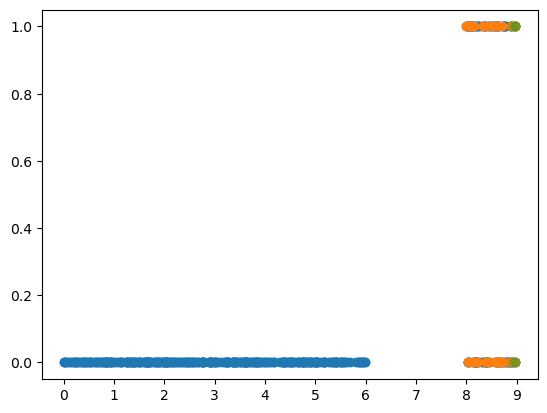

In [930]:
# Sanity check g1
y1 = np.where(y == 1)
plt.figure()
plt.xticks(xticks)
plt.scatter(X[g1][:,0], X[g1][:,1])
plt.scatter(X[np.intersect1d(y1, g1)][:,0], X[np.intersect1d(y1,g1)][:,1])

modelg1 = DecisionTreeClassifier(max_depth=3)
modelg1.fit(X[g1], y[g1])
ypredg1 = modelg1.predict(X)
ypredg1 = np.where(ypredg1 == 1)

plt.scatter(X[np.intersect1d(ypredg1, g1)][:,0], 
            X[np.intersect1d(ypredg1,g1)][:,1], alpha=0.25)

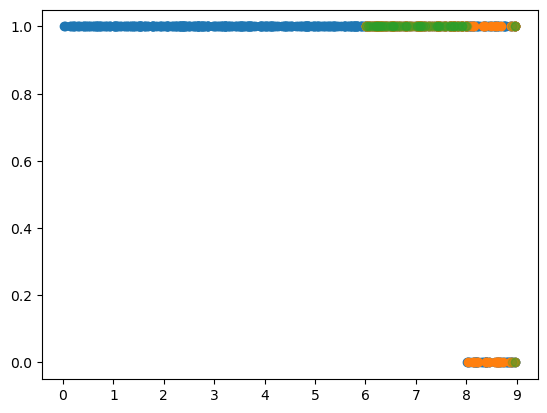

In [931]:
# Sanity check g1
y1 = np.where(y == 1)
plt.figure()
plt.xticks(xticks)
plt.scatter(X[g2][:,0], X[g2][:,1])
plt.scatter(X[np.intersect1d(y1, g2)][:,0], X[np.intersect1d(y1,g2)][:,1])

modelg2 = DecisionTreeClassifier(max_depth=4)
modelg2.fit(X[g2], y[g2])
ypredg2 = modelg2.predict(X)
ypredg2 = np.where(ypredg2 == 1)

plt.scatter(X[np.intersect1d(ypredg2, g2)][:,0], 
            X[np.intersect1d(ypredg2,g2)][:,1], alpha=0.25)

In [932]:
# Agreement on g1g2
print("L(h1 | g1) = {}".format(1 - accuracy_score(modelg1.predict(X[g1]), 
                                                  y[g1])))
print("L(h2 | g2) = {}".format(1 - accuracy_score(modelg2.predict(X[g2]), 
                                                  y[g2])))
print("Agreement on g1g2: {}".format(accuracy_score(modelg1.predict(X[g1g2]),
                                                    modelg2.predict(X[g1g2]))))

L(h1 | g1) = 0.07999999999999996
L(h2 | g2) = 0.05940594059405946
Agreement on g1g2: 0.9777777777777777


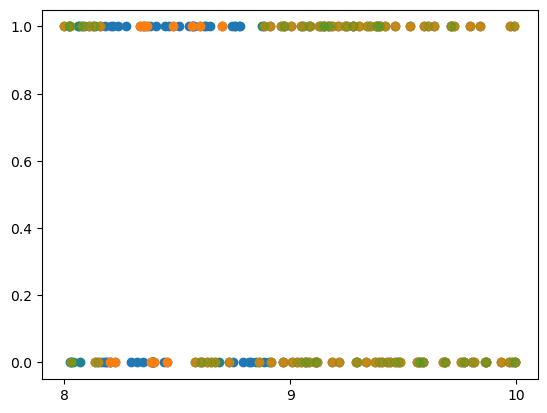

In [933]:
# Sanity check g3
y1 = np.where(y == 1)
plt.figure()
plt.xticks(xticks)
plt.scatter(X[g3][:,0], X[g3][:,1])
plt.scatter(X[np.intersect1d(y1, g3)][:,0], X[np.intersect1d(y1,g3)][:,1])

modelg3 = DecisionTreeClassifier(max_depth=4)
modelg3.fit(X[g3], y[g3])
ypredg3 = modelg3.predict(X)
ypredg3 = np.where(ypredg3 == 1)

plt.scatter(X[np.intersect1d(ypredg3, g3)][:,0], 
            X[np.intersect1d(ypredg3,g3)][:,1], alpha=0.25)
plt.show()


In [934]:
# Agreement on g1g2g3
print("L(h3 | g3) = {}".format(1 - accuracy_score(modelg3.predict(X[g3]), 
                                                  y[g3])))
print("Agreement on g1g2g3={}".format(accuracy_score(modelg1.predict(X[g1g2g3]),
                                                modelg3.predict(X[g1g2g3]))))

L(h3 | g3) = 0.12941176470588234
Agreement on g1g2g3=0.6666666666666666


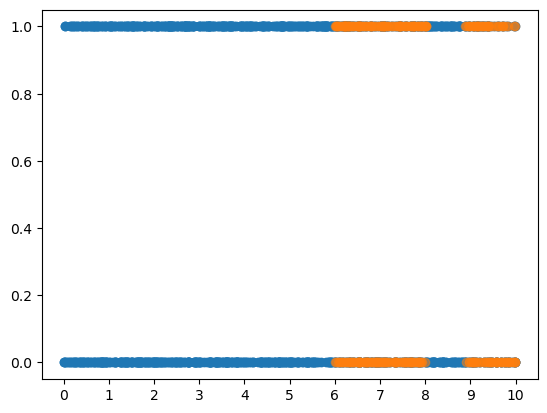

In [935]:
rf = RandomForestClassifier(n_estimators=10, max_depth=4)
rf.fit(X, y)
plt.figure()
plt.xticks(xticks)
plt.scatter(X[:,0], X[:,1])
ypred = rf.predict(X)
ypred = np.where(ypred == 1)

plt.scatter(X[ypred][:,0], 
            X[ypred][:,1], alpha=0.5)

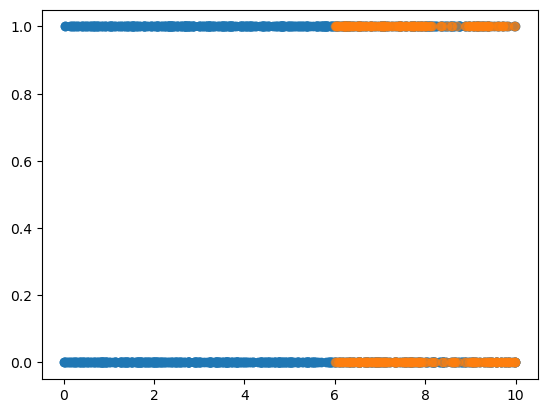

In [936]:
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[y1][:,0], 
            X[y1][:,1], alpha=0.5)

In [937]:
accuracy_score(rf.predict(X[g3]), y[g3])

0.8294117647058824

In [938]:
accuracy_score(modelg3.predict(X[g3]), y[g3])

0.8705882352941177

## Experiment 1: Vary noise level => Training Error Gap

## Experiment 2: Vary noise level => Test Error Gap